### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

/home/k/AI-Engineering-Bootcamp/01-ai-engineering-bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [4]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    retrieved_context_ratings = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [5]:
query = "Can I get some tablet"

In [6]:
answer = retrieve_data(query, qdrant_client, k=10)

In [7]:
answer

{'retrieved_context_ids': ['B0B8NVNQKX',
  'B09LH466KZ',
  'B0BR33XH8D',
  'B0BN7WWH63',
  'B0C3XYD574',
  'B0BL2CZSHT',
  'B0C78B1BTB',
  'B0BFGXRMJN',
  'B0C772GZRF',
  'B08CGM6Y1J'],
 'retrieved_context': ['COOPERS 7 inch Kids Tablet Android 11 Tablet for Kids, 2GB RAM + 32GB ROM Toddler Tablet PC for Children, IPS Touch Screen, Dual Camera, Dual Speaker, WiFi Computer Tablet, Light Blue ✿【Good Kids tablet】This 7 inch tablet for kids with silm body and lightweight, it is easy to hold by children. Also the special design can protect the tablet well when dropping. ✿【Parental Control】Toddlers Tablet with parent mode can add or block apps. Set screen time limits. This tablet come with iwawa app. kids can get access to fun and educational games and videos. ✿【Powerful Tablets】Equipmented with quad core CPU, Android 11.0 System, 32GB Big Storage, 1024*600 IPS Screen offer a clear view. Runs Kinds of apps and game for kids smoothly. ✿【Long Lasting】Tablet for kids built with large capacity b

### Multi-Intention Question

In [8]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"

In [9]:
answer = retrieve_data(query, qdrant_client, k=10)

In [10]:
answer

{'retrieved_context_ids': ['B0BRXZDBXZ',
  'B0BL2CZSHT',
  'B0C3XYD574',
  'B0B8NVNQKX',
  'B0CFFGT7RM',
  'B0C142QS8X',
  'B0BFGXRMJN',
  'B0C772GZRF',
  'B08CGM6Y1J',
  'B0BN7WWH63'],
 'retrieved_context': ["Kids Tablet, 7 inch Tablet for Kids 3GB RAM 32GB ROM, Android 11 Toddler Tablet with WiFi, Bluetooth, GMS, Parental Control, Shockproof Case, Google Play, YouTube, Netflix 【iWawa APP with parental control】This kids tablet has passed the GMS certification and is pre-installed with the iwawa app, specially designed for children. It has password control, remote video control, one-button lock screen and Learning, art, smart games. New-upgrade kids online school, fun interaction, video playback 【Android 11.0 & 128 GB Expand】Android 11.0 operating system, 3GB RAM 32GB ROM, support WiFi, Bluetooth, GPS, etc. The HD 1024*600IPS display can offer a perfect experience, You can expand the storage to 128 GB of SD cards for storing photos, music and videos. The upgraded battery can last more 

In [11]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [12]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [13]:
answer = query_expand_node(query)

In [14]:
answer

{'queries': ['tablet for kids', 'watch for adults', 'laptop for wives']}

# LangGraph

## Query Expansion (Sequential execution)

In [15]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

### Query Expansion / Rewriting Node

In [16]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [17]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

### Retriever Node

In [18]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve(query, k=10) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve(query))

    return {
        "retrieved_context": retrieved_context
    }

### Agregator Node

In [23]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [19]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [20]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retriever_node")
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

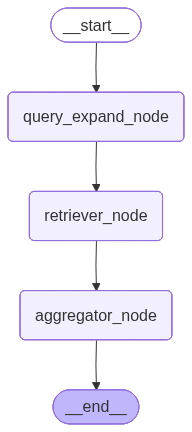

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [25]:
result

{'expanded_query': ['tablet for kids', 'watch for adults', 'laptop for women'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, du

In [26]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are the options:

1. Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - 10.1-inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM
  - 6000mAh battery
  - Kid-proof case with built-in stand
  - Parental controls, content filter, password protection
  - Dual cameras, Wi-Fi, Bluetooth

2. Watch for Adults:
- Several smartwatches available such as:
  - Blackview R5 Sports Modes Fitness Tracker
    - 24/7 heart rate monitor and sleep tracker
    - 24 sports modes
    - IP68 waterproof
    - Compatible with iOS 9.0 and Android 4.3+
  - WalkerFit A2 Pro Blood Pressure Monitor Watch
    - Heart rate and blood pressure monitoring
    - 20 professional fitness modes
    - Call, SMS, and SNS notifications
    - 1.4" touch screen
    - IP67 waterproof
  - Other fitness trackers with heart rate, sleep monitoring, waterproofing, and multiple sports modes.

3

## Query Expansion (Parallel Execution)

In [27]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

### Query Expansion / Rewriting Node

In [28]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [29]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

In [30]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

### Retriever Node

In [31]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

### Aggregator Node

In [32]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [33]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

### Graph

In [37]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

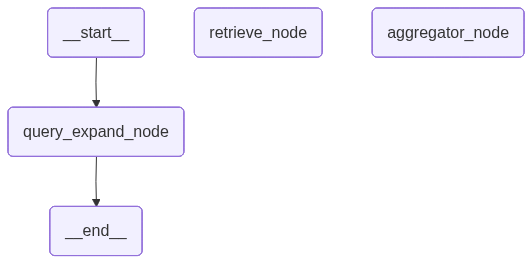

In [38]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [41]:
result

{'expanded_query': ['tablet for kid', 'watch for adult', 'laptop for wife'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, dual 

In [42]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are some options:

Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - 10.1 inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM storage
  - 6000mAh battery
  - Kid-proof case with built-in stand
  - GMS-certified with parental controls and content filter
  - Access to Google Play for apps like Gmail, Disney+, YouTube

Smart Watch for You:
- Blackview R5 Smart Watch
  - 24 sports modes
  - Heart rate monitor, blood oxygen SpO2
  - IP68 waterproof
  - Call notifications, SMS, app messages
  - Long battery life (9-15 days)
  - Compatible with iOS 9.0 and Android 4.3+

Laptop for Your Wife:
- Acer Aspire 5 A515-56-347N Slim Laptop
  - 15.6" Full HD IPS Display
  - 11th Gen Intel i3-1115G4 Dual Core Processor
  - 8GB DDR4 RAM
  - 128GB NVMe SSD
  - WiFi 6, Bluetooth, HDMI
  - Windows 11 Home in S Mode

These products offer a good balance of performa